# Проект: Обучение с учителем - качество модели

<div  style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">

__Цель:__ 
Разработать и внедрить систему персонализированных предложений для постоянных клиентов интернет-магазина «В один клик», чтобы повысить их покупательскую активность и удержать существующих работников.  
       
__Задачи:__       
     1. Разработать модель, которая предскажет вероятность снижения покупательской активности.   
     2. Выделить сегмент покупателей, проанализировать его и предложить, как увеличить его покупательскую активность. 
        
__План работы:__ 

1. [Загрузка данных](#1)
2. [Предобработка данных](#2)  
3. [Исследовательский анализ данных](#3)  
4. [Корреляционный анализ](#4)  
5. [Пайплайн](#5)  
6. [Анализ важности признаков](#6)  
7. [Сегментация покупателей](#7)
8. [Итоговый вывод](#8)

## Импорты и функции для выполнения проекта

In [1]:
pip install --upgrade scikit-learn -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install phik -q

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install shap -q

Note: you may need to restart the kernel to use updated packages.


In [4]:
#Импортируем необходимые библиотеки для работы 
import pandas as pd
from math import *
import numpy as np
from scipy import stats as st
# Метрики и оОбработка данных
from sklearn.metrics import (confusion_matrix, f1_score, roc_auc_score)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler, LabelEncoder)

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance

# Графическое отображение
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import shap

# Модели обучения
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

import warnings
warnings.filterwarnings("ignore")

#Зададим константы
TEST_SIZE = 0.25
RANDOM_STATE = 42

In [5]:
# Введем Функцию для отображения пропущенных значений для явных дубликатов
def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (10,5), legend = False)               

        );
        plt.title('Пропущенные значения, %' + "\n", fontsize=22)
        plt.xlabel('Процент пропусков', fontsize=18)
        plt.ylabel('Столбцы с пропусками',fontsize=18)
        plt.xlim(0, 100)  
    except:
        print('пропусков нет или произошла ошибка ')
        plt.title('Пропущенных значений нет', fontsize=32)

In [6]:
# Функция для отображения информации о датасете
def show_info(df):
    print('Количество строк выборки составляет:',df.shape[0],'\n')
    display('Первые пять строк', df.head())
    print('Общая информация о данных\n')
    print(df.info())
    display('Описание',df.describe().T)
    print('Количество явных дубликатов составляет',df.duplicated().sum())


In [7]:
#Функция для отображения уникальных значений в категориальных данных для поиска неявных дубликатов
def category_hide_duplicates(df):
    cat_col_names = df.select_dtypes(include='object').columns.tolist()
    for col in cat_col_names:
        print(col,':')
        print(df[col].unique())
        print('==================================')
    

In [8]:
#Функция отображения гистограм и боксплотов для исследовательского анализа
def search_plot(df_col, title_name, bins):

    mean = df_col.mean()
    median = df_col.median()
    
    fig, ax = plt.subplots(2, 1, figsize=(10, 10))
    fig.suptitle(f"{title_name}", fontsize=13)
    
    sns.histplot(df_col, bins=bins, kde=True, ax=ax[0])
    ax[0].set_title('Гистограмма', fontsize=10)
    ax[0].set_xlabel(title_name)
    ax[0].set_ylabel('Частота')
    ax[0].grid(True)
    
    ax[0].axvline(mean, color='red', linestyle='--', label=f'Среднее = {mean:.2f}')
    ax[0].axvline(median, color='purple', linestyle='-.', label=f'Медиана = {median:.2f}')
    ax[0].legend()

    sns.boxplot(x=df_col, ax=ax[1], color='pink')
    ax[1].set_title('Диаграмма размаха', fontsize=10)
    ax[1].axvline(median, color='green', linestyle='-.')
    ax[1].grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    
    
    display(df_col.describe().T)
    print('')
    
    stat, p = st.shapiro(df_col)
    alpha = 0.1  # Уровень значимости
    if p > alpha:
        print("По тесту Шапиро-Уилка: Распределение похоже на нормальное")
    else:
        print("По тесту Шапиро-Уилка: Распределение отличается от нормального")

In [9]:
def search_сategory(df,col,title_name):
    
    ratio = round(df.groupby(col)[col].count()/df[col].count()*100)
    
    ratio.plot(
    kind = 'pie',
    autopct='%1.1f%%',
    labels = ratio.index,
    figsize=(6,6),
    title = 'Круговая диаграмма соотношения признаков в данных '+ title_name,
    ylabel = '',
    fontsize = 12
    )
    display(ratio)

In [10]:
def short_search_plot(df_col, title_name, bins):

    mean = df_col.mean()
    median = df_col.median()
    
    plt.figure(figsize=(12, 8))
    
    fig = sns.histplot(df_col, bins=bins, kde=True)
    fig.set_title('Гистограмма', fontsize=10)
    fig.set_xlabel(title_name)
    fig.set_ylabel('Частота')
    fig.grid(True)
    
    fig.axvline(mean, color='red', linestyle='--', label=f'Среднее = {mean:.2f}')
    fig.axvline(median, color='purple', linestyle='-.', label=f'Медиана = {median:.2f}')
    fig.legend()

    plt.show()

In [11]:
def discrete_search_plot(df_col, title_name):

    plt.figure(figsize=(12, 8))
    
    fig = sns.countplot(x = df_col, edgecolor='black')
    fig.set_title('', fontsize=10)
    fig.set_xlabel(title_name)
    fig.set_ylabel('Количество')
    fig.grid(True)



    plt.show()

## Загрузка данных <a id='1'>

In [12]:
try:
    df_mar_file = pd.read_csv('/datasets/market_file.csv', sep =',')
    df_mar_money = pd.read_csv('/datasets/market_money.csv', sep =',')
    df_mar_time = pd.read_csv('/datasets/market_time.csv', sep =',')
    df_income = pd.read_csv('/datasets/money.csv', sep =';',decimal = ',')
except:
    df_mar_file = pd.read_csv('market_file.csv', sep =',')
    df_mar_money = pd.read_csv('market_money.csv', sep =',')
    df_mar_time = pd.read_csv('market_time.csv', sep =',')
    df_income = pd.read_csv('money.csv', sep =';',decimal = ',')
    
df_list=[df_mar_file, df_mar_money, df_mar_time, df_income]

### Содержание трех датасетов:   
1. __df_mar_file__:  

>Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.

`id` — номер покупателя в корпоративной базе данных.   
`Покупательская активность` — рассчитанный класс покупательской активности (целевой признак): `снизилась` или `прежний уровень`     
`Тип сервиса` — уровень сервиса, например `премиум` и `стандарт`.           
`Разрешить сообщать` — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.     
`Маркет_актив_6_мес` — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.   
`Маркет_актив_тек_мес` — количество маркетинговых коммуникаций в текущем месяце.   
`Длительность` — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.   
`Акционные_покупки` — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.   
`Популярная_категория` — самая популярная категория товаров у покупателя за последние 6 месяцев.   
`Средний_просмотр_категорий_за_визит` — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.   
`Неоплаченные_продукты_штук_квартал` — общее число неоплаченных товаров в корзине за последние 3 месяца.   
`Ошибка_сервиса` — число сбоев, которые коснулись покупателя во время посещения сайта.   
`Страниц_за_визит` — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

2. __df_mar_money__:   

>Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.  

`id` — номер покупателя в корпоративной базе данных.   
`Период` — название периода, во время которого зафиксирована выручка. Например, `текущий_месяц` или `предыдущий_месяц`.   
`Выручка` — сумма выручки за период.   

    
3) __df_mar_time__:      

> Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.    

`id` — номер покупателя в корпоративной базе данных.         
`Период` — название периода, во время которого зафиксировано общее время.     
`минут` — значение времени, проведённого на сайте, в минутах.        

3) __df_income__:    

>Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.     

`id` — номер покупателя в корпоративной базе данных.           
`прибыль`— значение прибыли.    

-----


In [13]:
i=1
for df in df_list:
    print(f'------------ ДАТАСЕТ №{i} ------------')
    show_info(df)
    print(f'\n------------------------------------')
    i+=1
          
    

------------ ДАТАСЕТ №1 ------------
Количество строк выборки составляет: 1300 



'Первые пять строк'

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


Общая информация о данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Оши

'Описание'

,count,mean,std,min,25%,50%,75%,max
id,1300.0,215997.500000,375.421985,215348.0,215672.75,215997.50,216322.25,216647.00
Маркет_актив_6_мес,1300.0,4.253769,1.014814,0.9,3.70,4.20,4.90,6.60
Маркет_актив_тек_мес,1300.0,4.011538,0.696868,3.0,4.00,4.00,4.00,5.00
Длительность,1300.0,601.898462,249.856289,110.0,405.50,606.00,806.00,1079.00
Акционные_покупки,1300.0,0.319808,0.249843,0.0,0.17,0.24,0.30,0.99
Средний_просмотр_категорий_за_визит,1300.0,3.270000,1.355350,1.0,2.00,3.00,4.00,6.00
Неоплаченные_продукты_штук_квартал,1300.0,2.840000,1.971451,0.0,1.00,3.00,4.00,10.00
Ошибка_сервиса,1300.0,4.185385,1.955298,0.0,3.00,4.00,6.00,9.00
Страниц_за_визит,1300.0,8.176923,3.978126,1.0,5.00,8.00,11.00,20.00


Количество явных дубликатов составляет 0

------------------------------------
------------ ДАТАСЕТ №2 ------------
Количество строк выборки составляет: 3900 



'Первые пять строк'

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


Общая информация о данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB
None


'Описание'

,count,mean,std,min,25%,50%,75%,max
id,3900.0,215997.500000,375.325686,215348.0,215672.75,215997.5,216322.25,216647.0
Выручка,3900.0,5025.696051,1777.704104,0.0,4590.15,4957.5,5363.00,106862.2


Количество явных дубликатов составляет 0

------------------------------------
------------ ДАТАСЕТ №3 ------------
Количество строк выборки составляет: 2600 



'Первые пять строк'

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


Общая информация о данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB
None


'Описание'

,count,mean,std,min,25%,50%,75%,max
id,2600.0,215997.500000,375.349754,215348.0,215672.75,215997.5,216322.25,216647.0
минут,2600.0,13.336154,4.080198,4.0,10.00,13.0,16.00,23.0


Количество явных дубликатов составляет 0

------------------------------------
------------ ДАТАСЕТ №4 ------------
Количество строк выборки составляет: 1300 



'Первые пять строк'

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


Общая информация о данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB
None


'Описание'

,count,mean,std,min,25%,50%,75%,max
id,1300.0,215997.500000,375.421985,215348.00,215672.75,215997.500,216322.25,216647.00
Прибыль,1300.0,3.996631,1.013722,0.86,3.30,4.045,4.67,7.43


Количество явных дубликатов составляет 0

------------------------------------


In [14]:
#Создадим переменную в которой будет хранится значение количества исходных сырых данных
raw_data_count = df_mar_file.shape[0]

### Итог загрузки данных

<div  style="border-radius: 10px; border: 2px solid; padding: 40px ">

К датафреймам нет замечаний. Все признаки соответствуют описанию, пропуски в данных отсутсвуют. Далее будут проведены дополнительные работы по качеству данных и, в случае необходимости, исправлены.

----------


## Предобработка данных <a id='2'>

Проверим неявные дубликаты в датафреймах


In [15]:
category_hide_duplicates(df_mar_file)

Покупательская активность :
['Снизилась' 'Прежний уровень']
Тип сервиса :
['премиум' 'стандартт' 'стандарт']
Разрешить сообщать :
['да' 'нет']
Популярная_категория :
['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']


В `Тип сервиса` присутсвует дубликат "__стандартт__ "    
Исправим:

In [16]:
df_mar_file['Тип сервиса'] = df_mar_file['Тип сервиса'].replace('стандартт','стандарт')
df_mar_file['Тип сервиса'].unique()

array(['премиум', 'стандарт'], dtype=object)

In [17]:
category_hide_duplicates(df_mar_money)


Период :
['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']


Здесь все хорошо!

In [18]:
category_hide_duplicates(df_mar_time)

Период :
['текущий_месяц' 'предыдцщий_месяц']


Проверим, что нет дубликатов по уникальному индификатору `id`

Исправим орфографическую ошибку


In [19]:
df_mar_time['Период'] = df_mar_time['Период'].replace('предыдцщий_месяц','предыдущий_месяц')
df_mar_time['Период'].unique()

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

------

Проверим, что нет дубликатов по уникальному индификатору `id`

### Итог по обработке данных


<div  style="border-radius: 10px; border: 2px solid; padding: 40px ">

1. В первом датафрейме устранили неявные дубликаты   
2. Во третьем датафрейме исправили орфографическую ошибку   
    
После корректировок замечаний к данным нет.


----


## Исследовательский анализ <a id='3'>

### Анализ количественных переменных 1-го датафрейма

Так как id нас не интересует, то его не будем рассматривать в исследовательском анализе

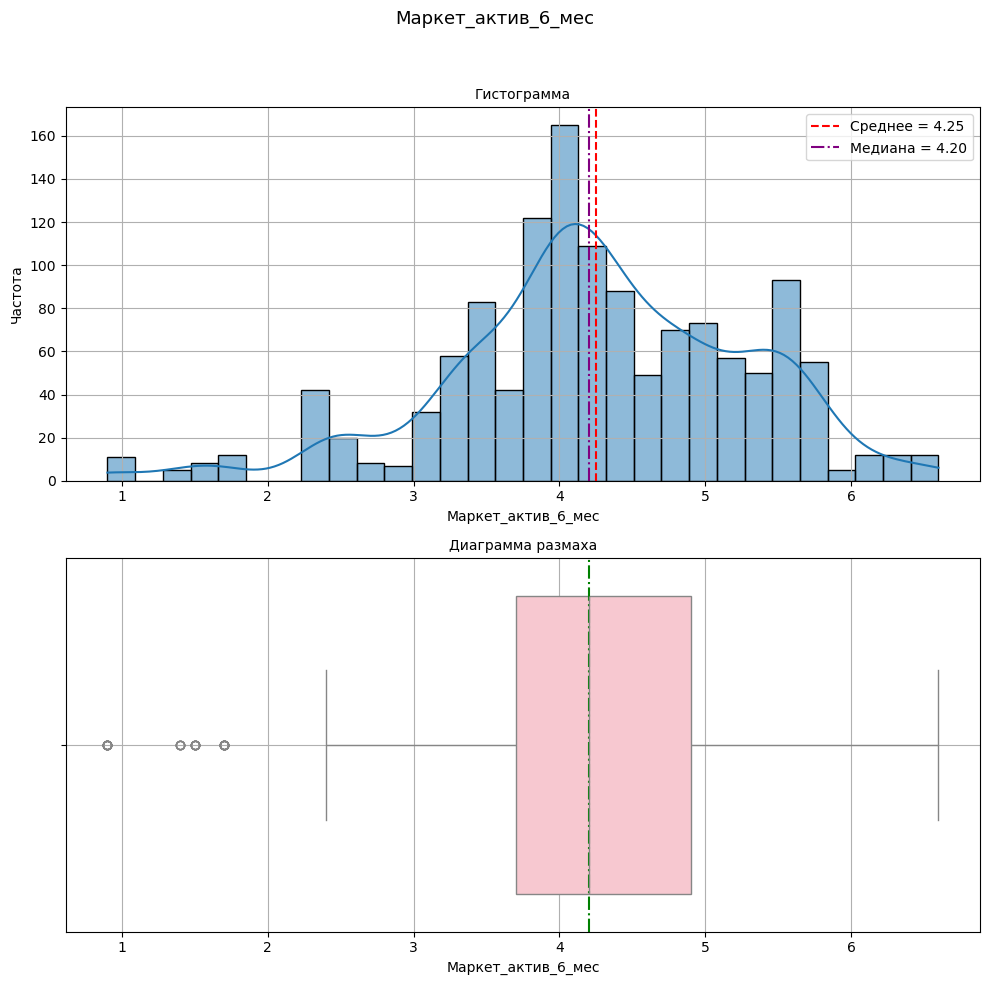

count    1300.000000
mean        4.253769
std         1.014814
min         0.900000
25%         3.700000
50%         4.200000
75%         4.900000
max         6.600000
Name: Маркет_актив_6_мес, dtype: float64


По тесту Шапиро-Уилка: Распределение отличается от нормального


In [20]:
search_plot(df_mar_file['Маркет_актив_6_мес'], 'Маркет_актив_6_мес', bins = 30)

- По тесту Шапиро-Уилка: Распределение отличается от нормального, несмотря на графическое представление.    
- Выбросы незначительные и удалять их не будем.    
- Медиана и среднее значение почти равны   

-----

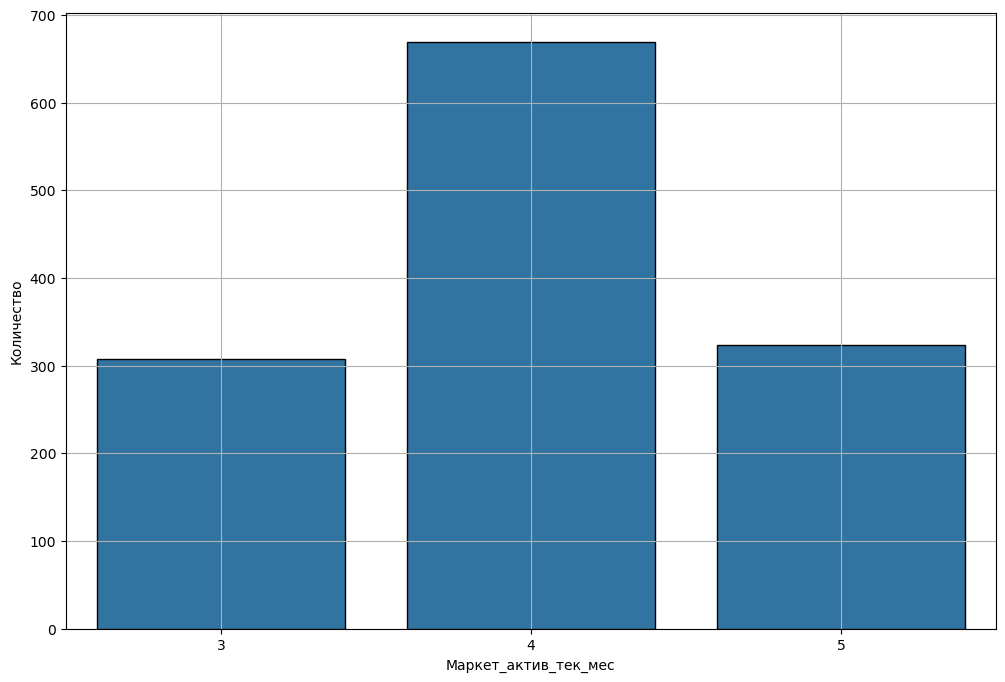

In [21]:
discrete_search_plot(df_mar_file['Маркет_актив_тек_мес'], 'Маркет_актив_тек_мес')

Распределение похоже на нормальное    
Можно отметить, что в текущем месяце среднее значение маркетинговых активностей было около 4-х

-----

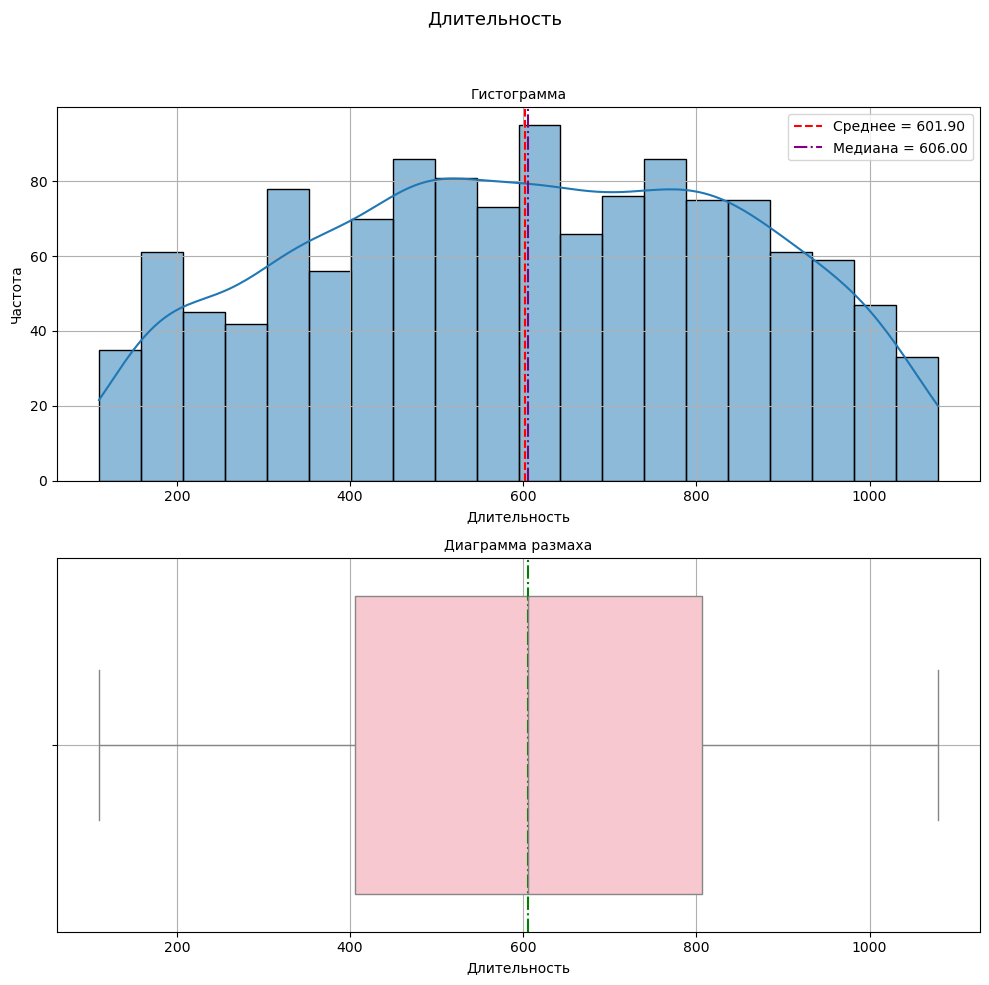

count    1300.000000
mean      601.898462
std       249.856289
min       110.000000
25%       405.500000
50%       606.000000
75%       806.000000
max      1079.000000
Name: Длительность, dtype: float64


По тесту Шапиро-Уилка: Распределение отличается от нормального


In [22]:
search_plot(df_mar_file['Длительность'], 'Длительность', bins = 20)

- По тесту Шапиро-Уилка: Распределение отличается от нормального, несмотря на графическое представление.    
- Выбросы отсутствуют.    
- Медиана и среднее значение почти равны
- По боксплоту видно и гистограмме видно, что данные довольно плотно и равномерно распределены от 400 до 800,   
    по этой причине "верхушку колокола" как будто "срезали"

-----

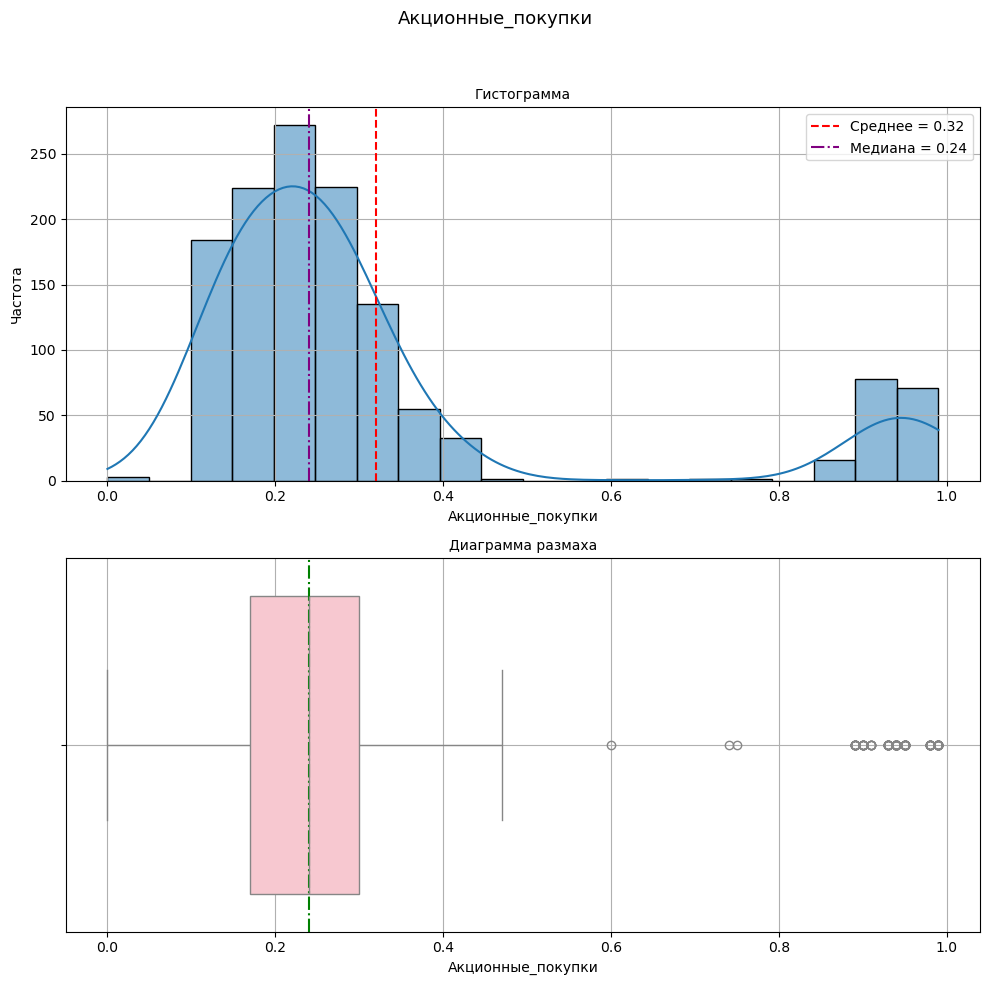

count    1300.000000
mean        0.319808
std         0.249843
min         0.000000
25%         0.170000
50%         0.240000
75%         0.300000
max         0.990000
Name: Акционные_покупки, dtype: float64


По тесту Шапиро-Уилка: Распределение отличается от нормального


In [23]:
search_plot(df_mar_file['Акционные_покупки'], 'Акционные_покупки', bins = 20)

- распределение бимодальное, на графике виден второй колокол возле максимальных значений.    
- выбросы присутствуют,но удалять их не будем, так как это скорее всего клиенты, которые покупают исключительно акционные товары. Также можно отметить, что большинство покупателей не стремятся взять что-то по акции -- это говорит о том, что акции интересны или доступны только определенному кластеру людей.           
- среднее значение почти на 25% больше медианного

-----

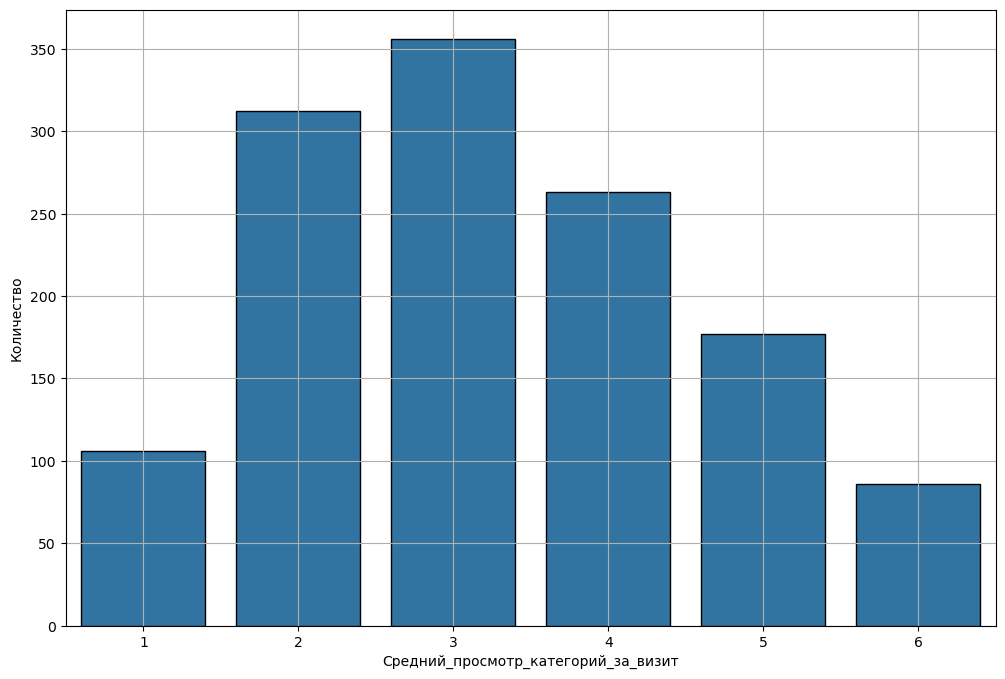

In [24]:
discrete_search_plot(df_mar_file['Средний_просмотр_категорий_за_визит'], 'Средний_просмотр_категорий_за_визит')

- распределение похоже на распределение Пуассона.          
- отсутсвуют пользователи, которые не посмотрели бы товары
- пользователи чаще всего просматривают 2-4 категории

-----

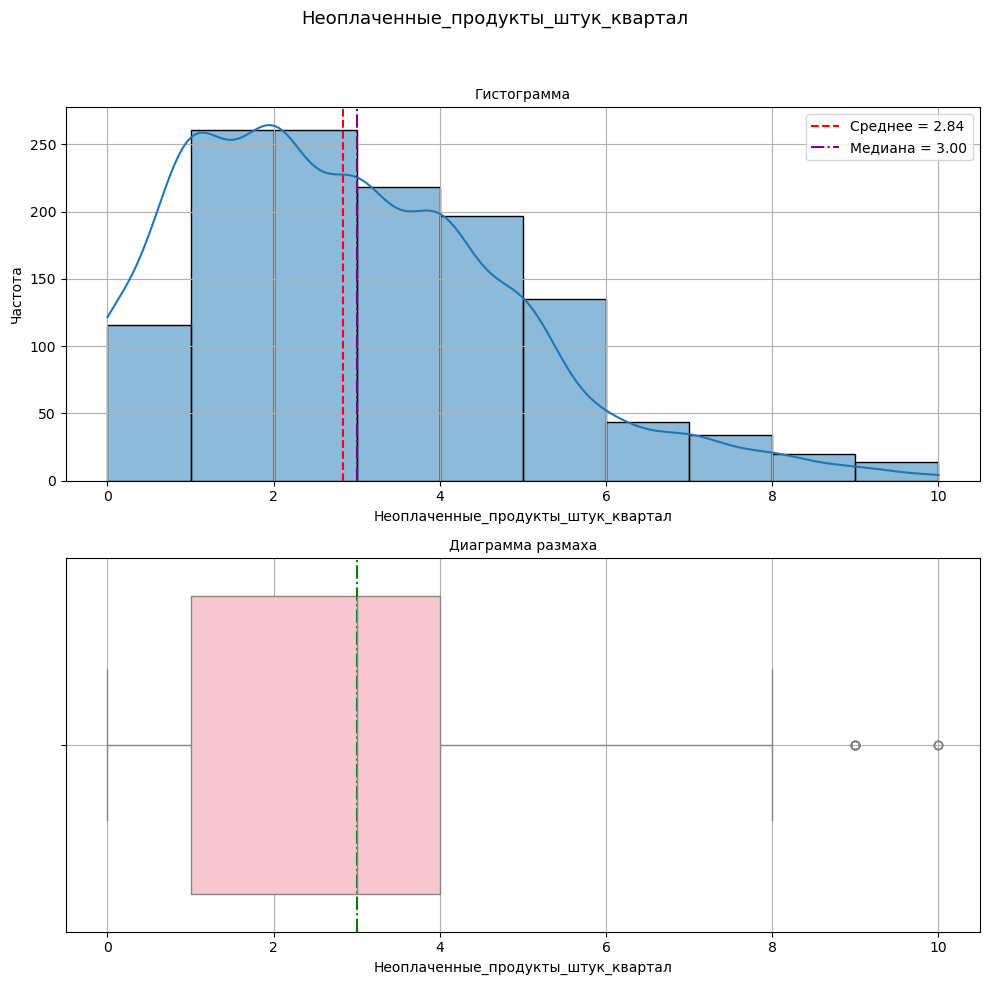

count    1300.000000
mean        2.840000
std         1.971451
min         0.000000
25%         1.000000
50%         3.000000
75%         4.000000
max        10.000000
Name: Неоплаченные_продукты_штук_квартал, dtype: float64


По тесту Шапиро-Уилка: Распределение отличается от нормального


In [25]:
search_plot(df_mar_file['Неоплаченные_продукты_штук_квартал'], 'Неоплаченные_продукты_штук_квартал', bins = 10)

- на графике наблюдается распределение Пуассона.    
- выбросы отсутсвуют.            
- среднее значение ниже медианы.      
- возможно в приложении отсутсвует функционал "Избранное" и так люди хранят товары, которые возможно купят в будущем.

-----

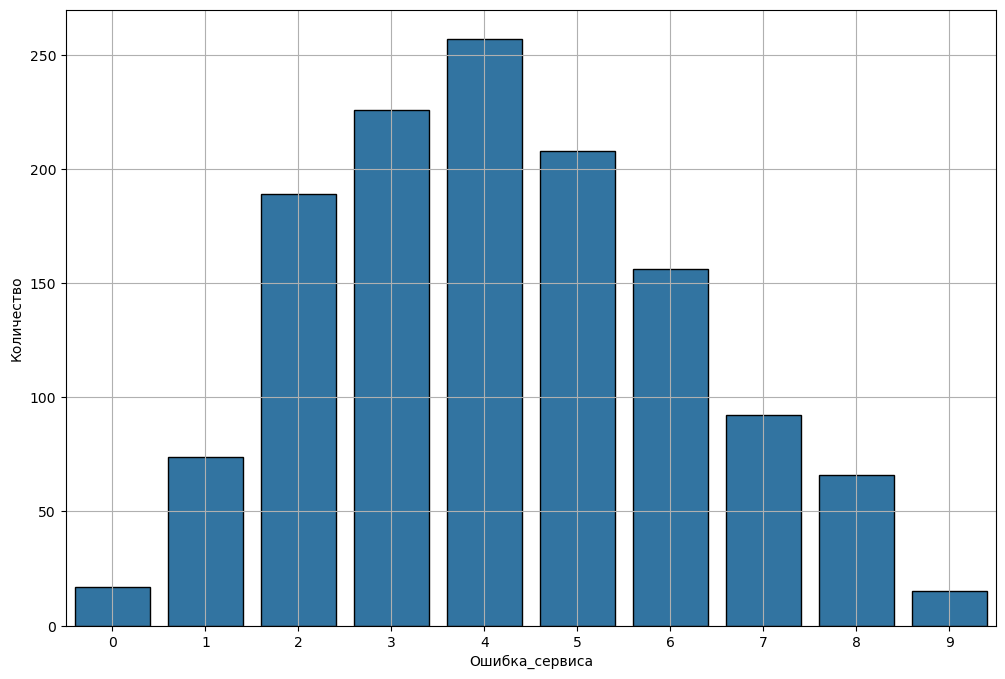

In [26]:
discrete_search_plot(df_mar_file['Ошибка_сервиса'], 'Ошибка_сервиса')

- распределение похоже на нормальное.    
- среднее количество сбоев от 3 до 5
-----

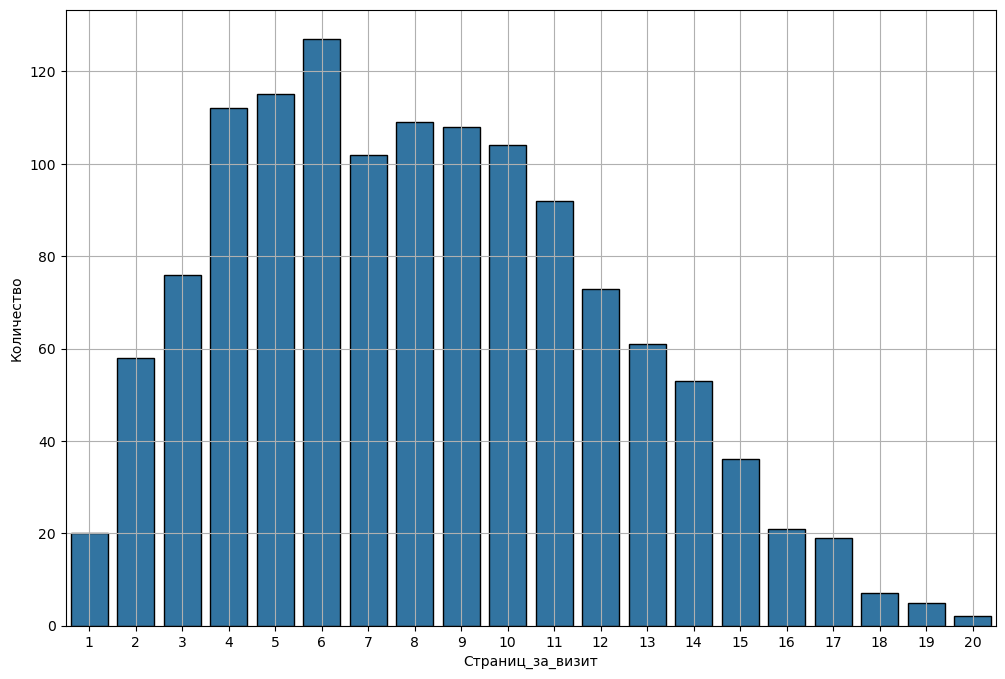

In [27]:
discrete_search_plot(df_mar_file['Страниц_за_визит'], 'Страниц_за_визит')

- распределение похоже на распределение Пуассона.    
- выбросы отсутсвуют.  
- большинство пользователей посещают от 4 до 10 страниц

-----

### Анализ количественных переменных 2-го датафрейма

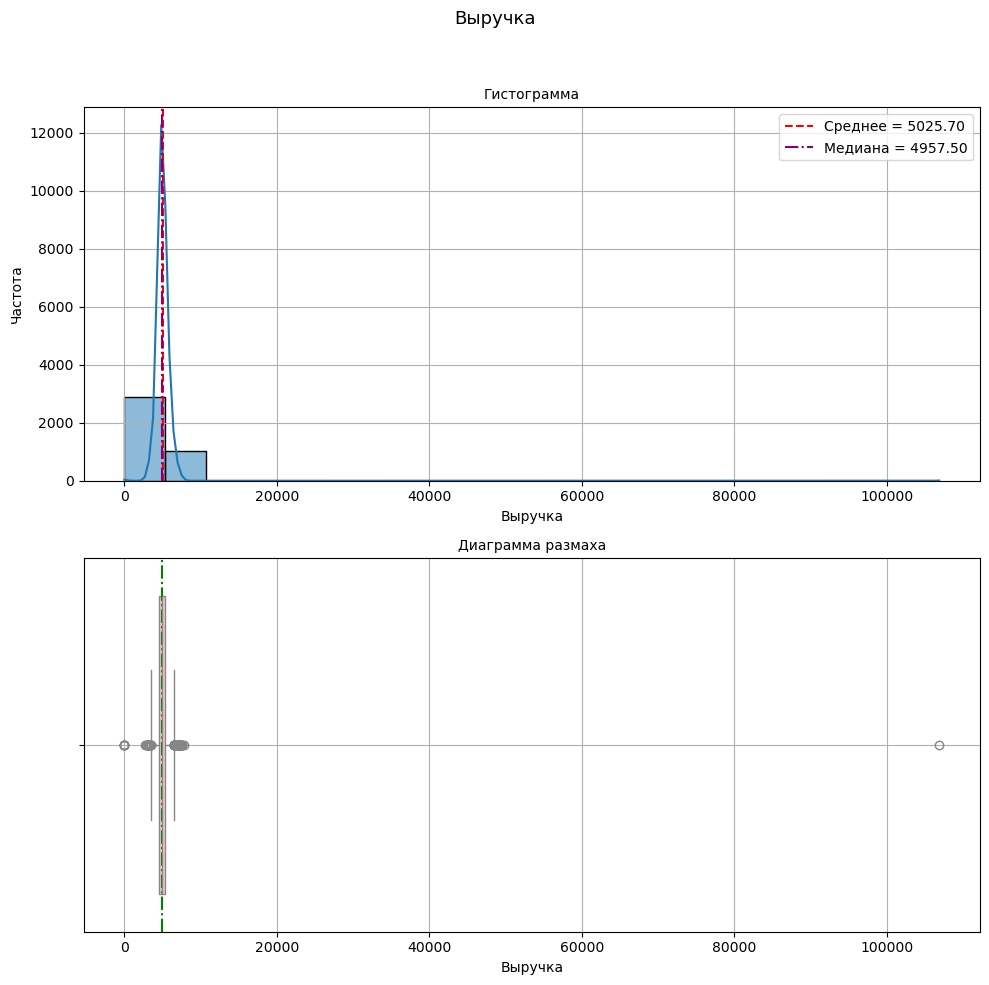

count      3900.000000
mean       5025.696051
std        1777.704104
min           0.000000
25%        4590.150000
50%        4957.500000
75%        5363.000000
max      106862.200000
Name: Выручка, dtype: float64


По тесту Шапиро-Уилка: Распределение отличается от нормального


In [28]:
search_plot(df_mar_money['Выручка'], 'Выручка', bins = 20)

Здесь наблдается аномальный выброс в значении 106862 и значении 0. Возможно данный клиент покупал что-то дорогое, но он сильно выделяется среди остальных данных. Так что его мы удалим.


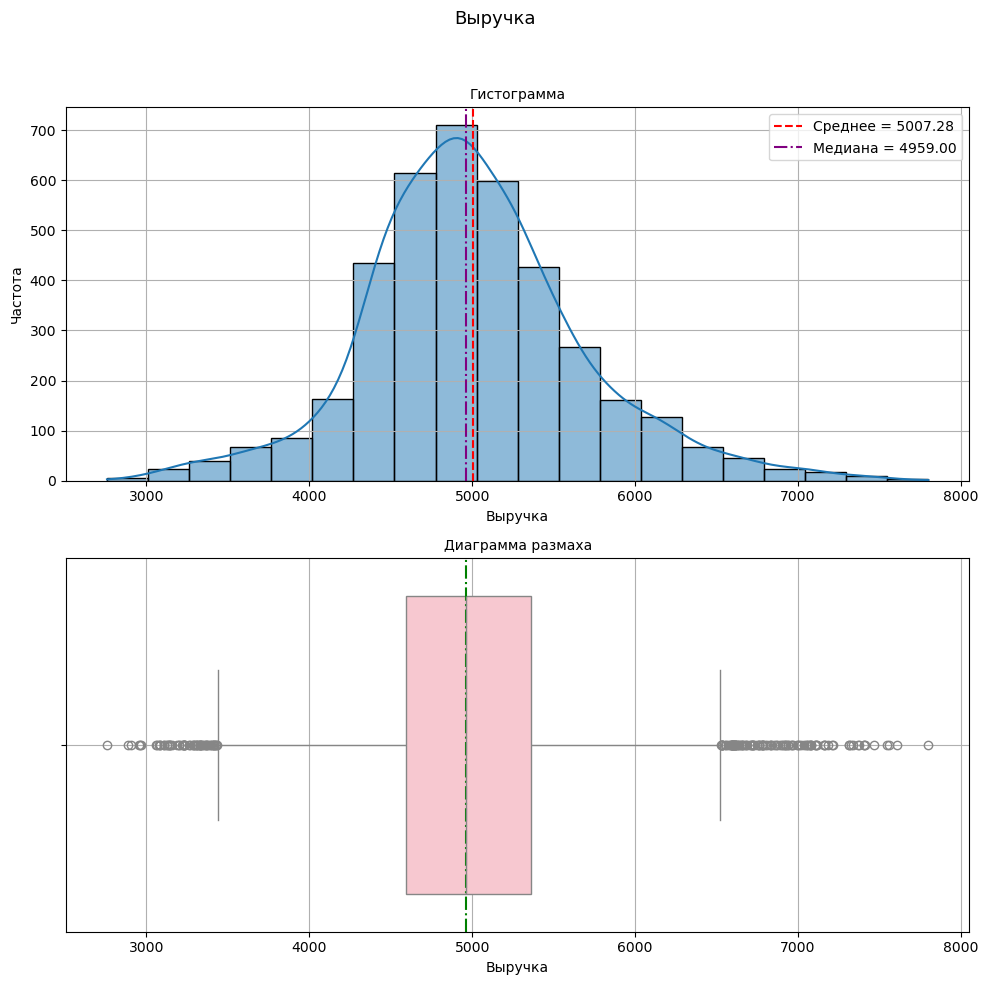

count    3893.000000
mean     5007.282918
std       679.724898
min      2758.700000
25%      4592.000000
50%      4959.000000
75%      5363.000000
max      7799.400000
Name: Выручка, dtype: float64


По тесту Шапиро-Уилка: Распределение отличается от нормального


In [29]:
df_mar_money = df_mar_money.query('Выручка != 106862.2 and Выручка != 0')
search_plot(df_mar_money['Выручка'], 'Выручка', bins = 20)

- распределение похоже на нормальное.    
- присутсвуют выбросы, но это не похоже на аномальные значения, так что их ужалять не будем.            
- среднее значение выше медианы, разница меньше 1%.      

-----

### Анализ количественных переменных 3-го и 4-го датафрейма

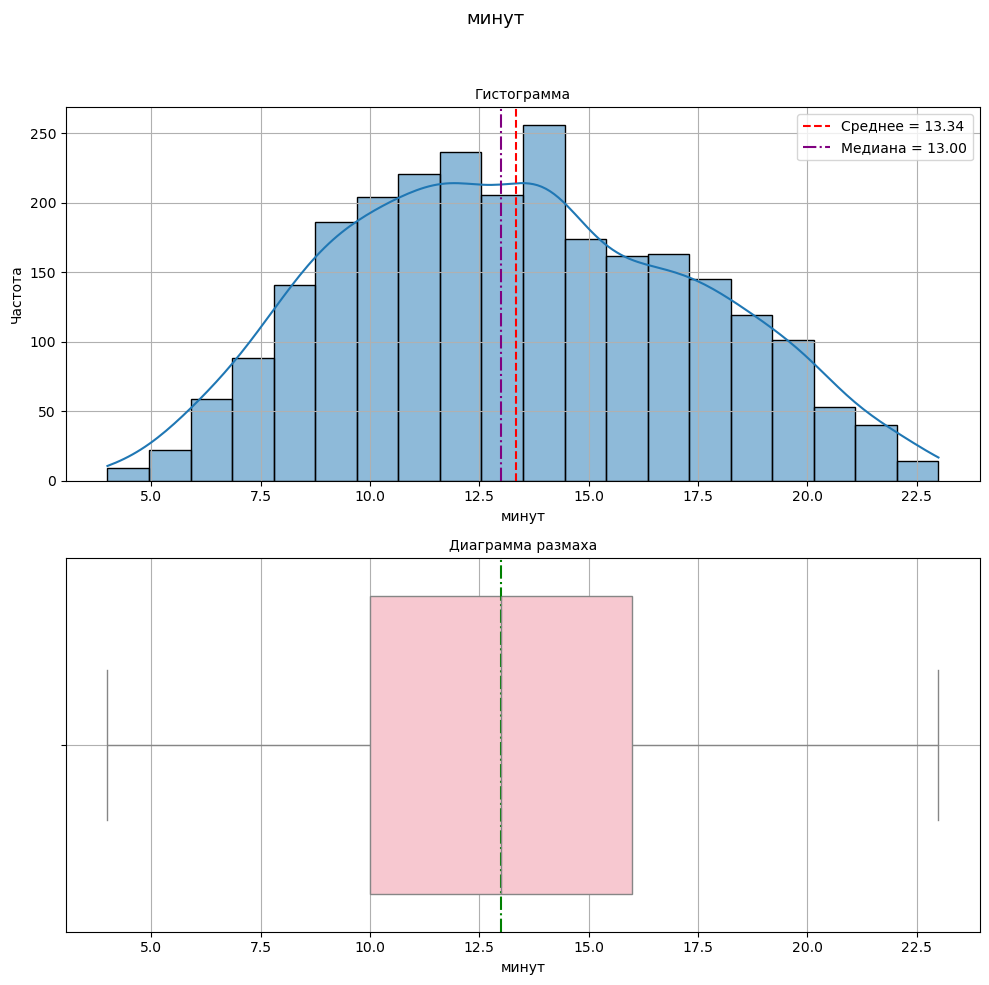

count    2600.000000
mean       13.336154
std         4.080198
min         4.000000
25%        10.000000
50%        13.000000
75%        16.000000
max        23.000000
Name: минут, dtype: float64


По тесту Шапиро-Уилка: Распределение отличается от нормального


In [30]:
search_plot(df_mar_time['минут'], 'минут', bins = 20)

- распределение похоже на нормальное, но слишком большая дисперсия.    
- выбросы отсутствуют.            
- среднее значение выше медианы     


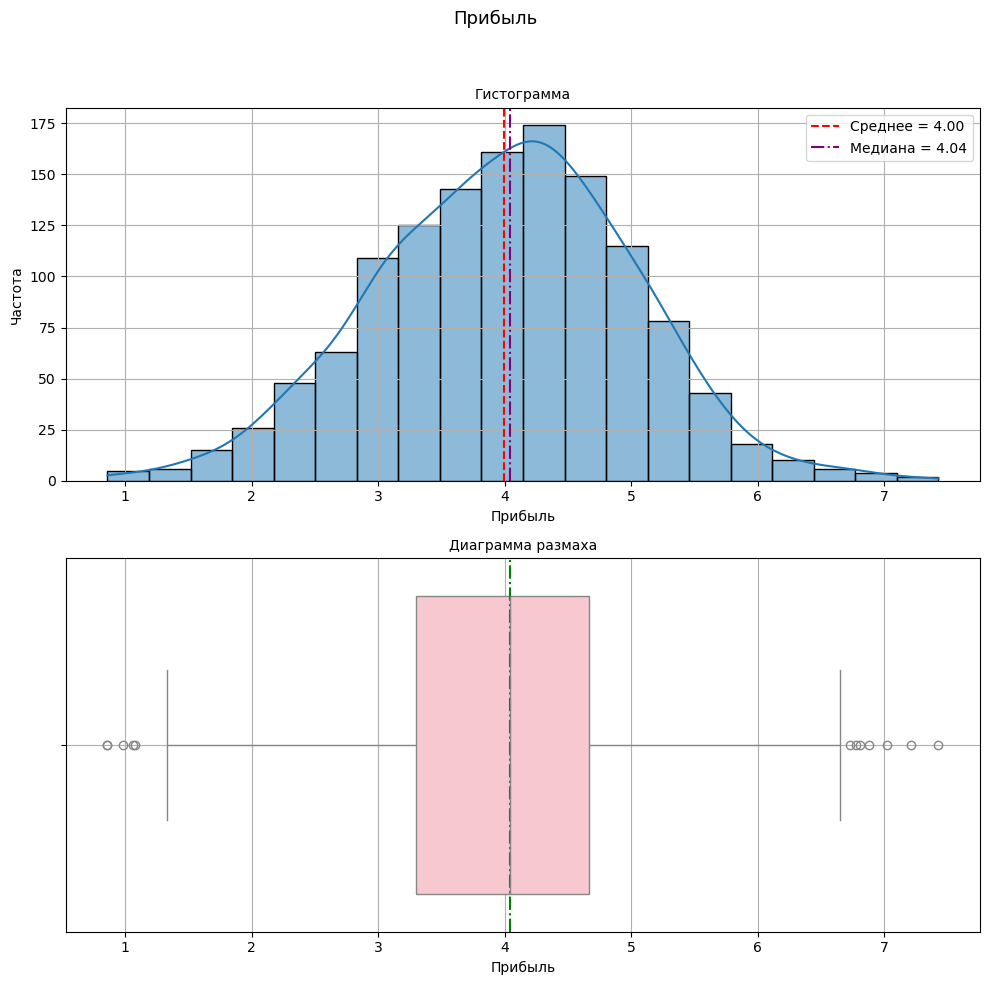

count    1300.000000
mean        3.996631
std         1.013722
min         0.860000
25%         3.300000
50%         4.045000
75%         4.670000
max         7.430000
Name: Прибыль, dtype: float64


По тесту Шапиро-Уилка: Распределение похоже на нормальное


In [32]:
search_plot(df_income['Прибыль'], 'Прибыль', bins = 20)

- распределение похоже на нормальное.   
- выбросы отсутствуют.            
- среднее значение и медиана почти равны 

### Анализ категориальных переменных 1-го датафрейма

Покупательская активность
Прежний уровень    62.0
Снизилась          38.0
Name: Покупательская активность, dtype: float64

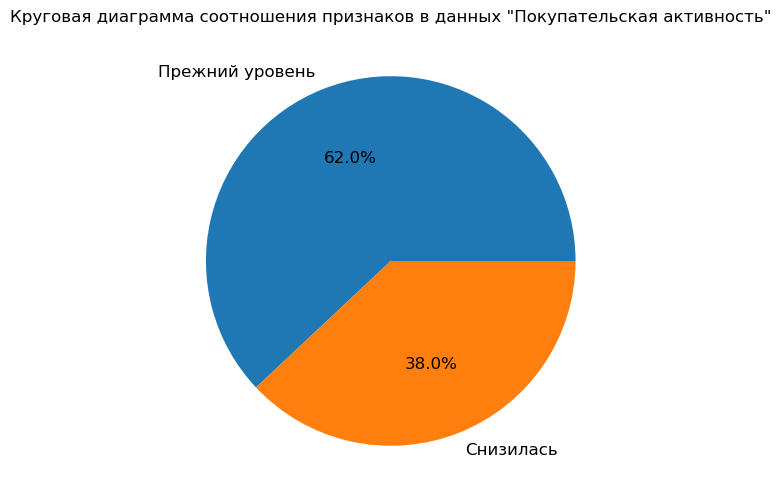

In [33]:
search_сategory(df_mar_file, 'Покупательская активность', '"Покупательская активность"')

- относительно сбалансированные данные, но мажорный класс - "Прежний уровень"    
- видно большое количество пользователей с низкой покупательсой активностей -> необходимо исправлять)
----


Тип сервиса
премиум     29.0
стандарт    71.0
Name: Тип сервиса, dtype: float64

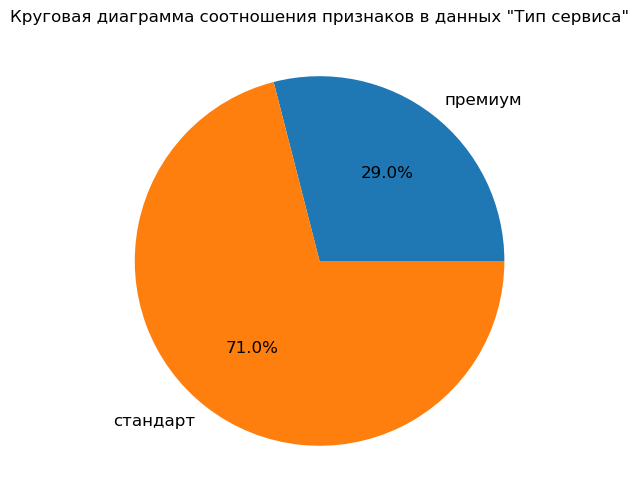

In [34]:
search_сategory(df_mar_file, 'Тип сервиса', '"Тип сервиса"')

наблюдается дисбаланс классов, премиум пользователей обычно всегда меньше обычных.    
Мажорный класс - "стандарт"

---

Разрешить сообщать
да     74.0
нет    26.0
Name: Разрешить сообщать, dtype: float64

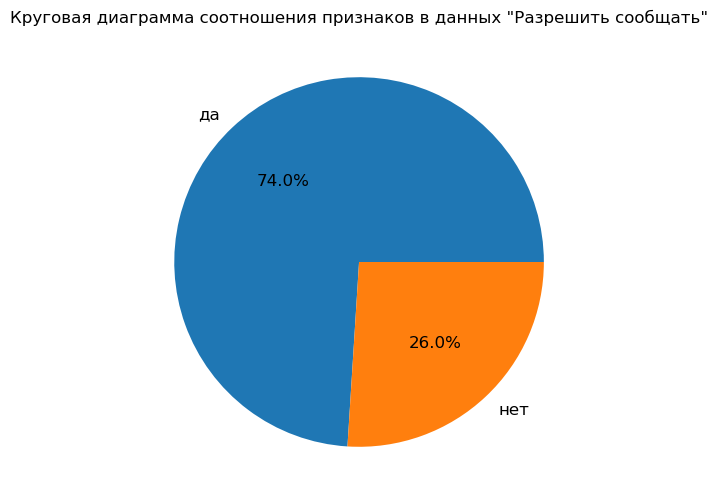

In [35]:
search_сategory(df_mar_file, 'Разрешить сообщать', '"Разрешить сообщать"')

Наблюдается дисбаланс классов. Мажорный класс - "да"

---


Популярная_категория
Домашний текстиль                       19.0
Косметика и аксесуары                   17.0
Кухонная посуда                         11.0
Мелкая бытовая техника и электроника    13.0
Техника для красоты и здоровья          14.0
Товары для детей                        25.0
Name: Популярная_категория, dtype: float64

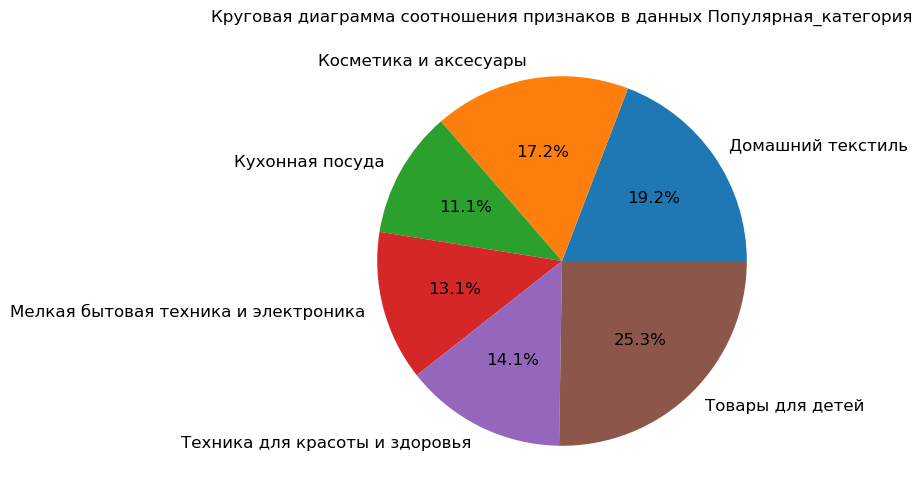

In [36]:
search_сategory(df_mar_file, 'Популярная_категория', 'Популярная_категория')

Наблюдается дисбаланс классов. Мажорный класс - "Товары для детей"

Период
предыдущий_месяц       33.0
препредыдущий_месяц    33.0
текущий_месяц          33.0
Name: Период, dtype: float64

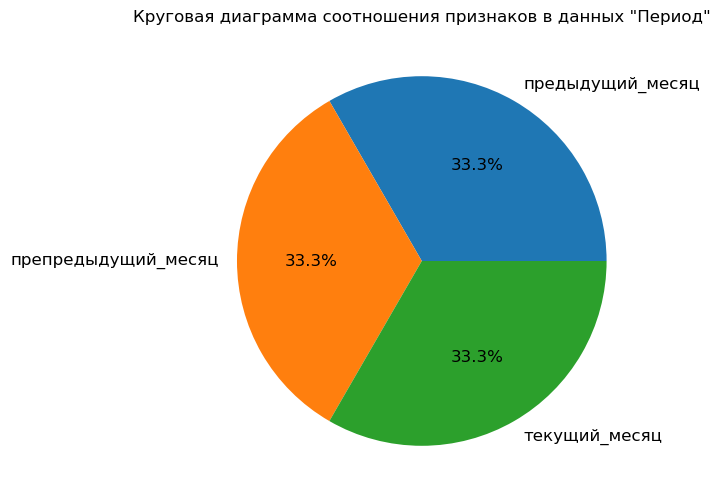

In [37]:
search_сategory(df_mar_money, 'Период', '"Период"')

Период
предыдущий_месяц    50.0
текущий_месяц       50.0
Name: Период, dtype: float64

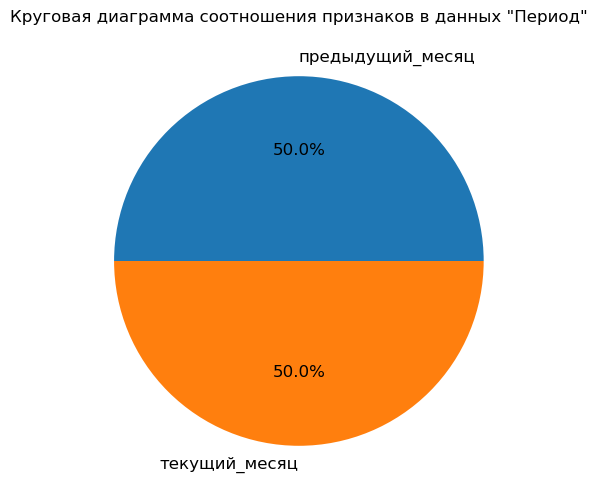

In [38]:
search_сategory(df_mar_time, 'Период', '"Период"')

Во втором и третьем датафрейме категориальные данные сбалансированы
В четвертом датафрейме категориальные данные отсутствуют.

### Итог по обработке данных

<div  style="border-radius: 10px; border: 2px solid; padding: 40px ">

Был проведен исследовательский анализ данных и сформулированы следующие выводы:

* Количественные признаки имеют нормальное или близкое к нормальному распределение, за исключением нескольких признаков с выбросами. Также встречаются признаки с бимодальным или распределением Пуассона.
    
* Категориальные данные показывают дисбаланс классов, что требует внимания при дальнейшей работе.
    
* Необходимо улучшить покупательскую активность для увеличении прибыли.

## Корреляционный анализ <a id='4'>

### Соединение таблиц

Перед началом корреляционного анализа необходимо объединить все таблицы в один датафрейм за исключением 4-го датафрейма, так как по заданю для моделирования он нам не понадобится по условию задачи.      

Сначала разделим во втором и третьем датафрейме данные по периодам, а затем объединим таблицы.

In [39]:
df_mar_money = df_mar_money.pivot_table(
    index = 'id',
    columns = 'Период',
    values = 'Выручка',
    aggfunc = 'first'
).reset_index()
df_mar_money.columns.name=None
display(df_mar_money.head())
print('Пропусков после изменений:\n', df_mar_money.isna().sum())

,id,предыдущий_месяц,препредыдущий_месяц,текущий_месяц
0,215348,NaN,NaN,3293.1
1,215349,5216.0,4472.0,4971.6
2,215350,5457.5,4826.0,5058.4
3,215351,6158.0,4793.0,6610.4
4,215352,5807.5,4594.0,5872.5


Пропусков после изменений:
 id                     0
предыдущий_месяц       3
препредыдущий_месяц    3
текущий_месяц          1
dtype: int64


>Обнаружены пропуски, так как после удаления выбросов образовались nan. Так как  таких данных немного, то удалим их

In [40]:
df_mar_money = df_mar_money.dropna()
df_mar_money.isna().sum()

id                     0
предыдущий_месяц       0
препредыдущий_месяц    0
текущий_месяц          0
dtype: int64

>Переименуем столбцы, так как в 3-м датафрейме они сходятся

In [41]:
df_mar_money = df_mar_money.rename(
    columns = {
        'предыдущий_месяц':'предыдущий_месяц_выручка',
        'препредыдущий_месяц':'позапрошлый_месяц_выручка',
        'текущий_месяц':'текущий_месяц_выручка'
    }
)
df_mar_money.head(1)

,id,предыдущий_месяц_выручка,позапрошлый_месяц_выручка,текущий_месяц_выручка
1,215349,5216.0,4472.0,4971.6


>Пропуски отсутствуют и название столбцов изменены. Проделаем тоже самое с 3-м датафреймом.

---


In [42]:
df_mar_time = df_mar_time.pivot_table(
    index = 'id',
    columns = 'Период',
    values = 'минут',
    aggfunc = 'first'
).reset_index()
df_mar_time.columns.name=None
display(df_mar_time.head())
print('Пропусков после изменений:\n',df_mar_time.isna().sum())

,id,предыдущий_месяц,текущий_месяц
0,215348,13,14
1,215349,12,10
2,215350,8,13
3,215351,11,13
4,215352,8,11


Пропусков после изменений:
 id                  0
предыдущий_месяц    0
текущий_месяц       0
dtype: int64


In [43]:
df_mar_time = df_mar_time.rename(
    columns = {
        'предыдущий_месяц':'предыдущий_месяц_минуты',
        'текущий_месяц':'текущий_месяц_минуты'
    }
)
df_mar_time.head(1)

,id,предыдущий_месяц_минуты,текущий_месяц_минуты
0,215348,13,14


>Соединим все данные в один датафрейм:

In [44]:
df = pd.merge(df_mar_file,
              pd.merge(df_mar_money,
                       df_mar_time,
                       on = 'id',
                      ),
              on = 'id'
             )
df.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,предыдущий_месяц_выручка,позапрошлый_месяц_выручка,текущий_месяц_выручка,предыдущий_месяц_минуты,текущий_месяц_минуты
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10


In [45]:
ratio=1 - df.shape[0]/raw_data_count
print(f'После обработки данных и соединения таблиц было потеряно {round(ratio*100,2)}% данных'
)

После обработки данных и соединения таблиц было потеряно 0.31% данных


Объединение выполнено успешно. Потеряно меньше 1% данных. Можно приступать к корреляционнному анализу

### Корреляционный анализ

> Проведем корреляционный анализ признаков в количественной шкале в итоговой таблице для моделирования. 

    так как не все данные имеют нормальное распределение, то будем пользоваться методом Phik, который более устойчив     
    к ненормальному распределению, а также посмотреть корреляцию в категориальных данных.

In [46]:
# Так как id не понадобится в коррелционном анализе, то сделаем его индексами
df = df.set_index('id')
# Отберем столбцы с количественными данными
num_col = df.select_dtypes(include = 'number').columns

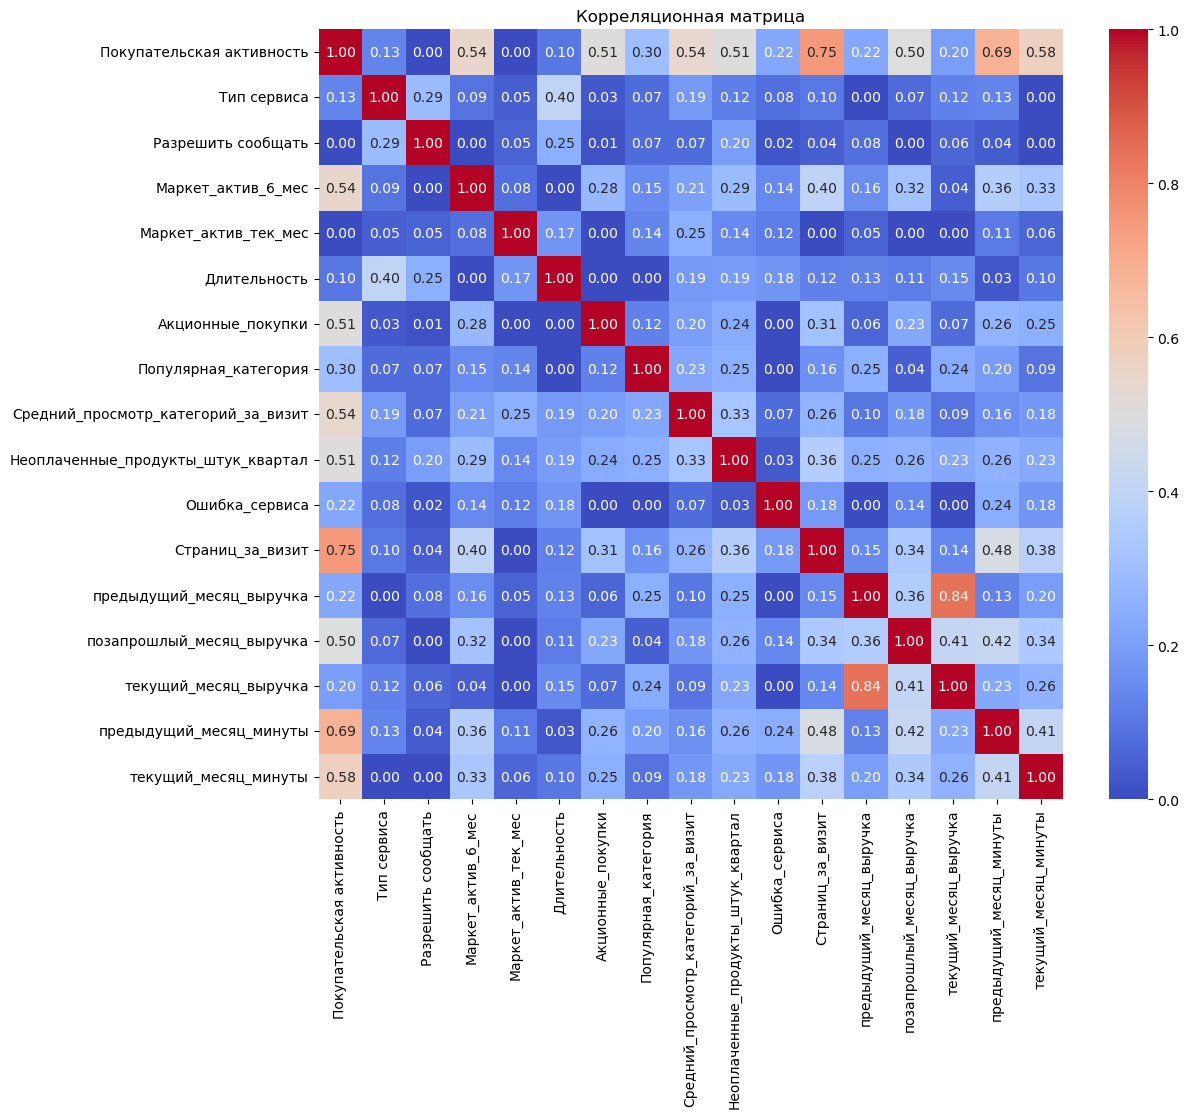

In [47]:
phik_matrix = df.phik_matrix(interval_cols=num_col)

plt.figure(figsize=(12, 10))
sns.heatmap(phik_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Корреляционная матрица')
plt.show()

По матрице корреляции можно сделать следующие выводы:    
     
1. наблюдается корреляций входных признаков выручки за предыдущий и текущий месяц, но нет признака мультиколлинеарности    
2. наиболее коррелируемые признаки с целевым это:
    - время проведенное в приложении    
    - маркетинговая активность за 6 мес
    - страниц за визит
    - средний просмотр категорий за визит
    - неоплаченные продукты
3. Маркетинговая активность за текущий месяц не коррелирует с целевы признаком в отличии за предыдущие 6 месяцев. Возможно изменился подход, так как отсутсвует корреляция с выручкой текущего месяца.

### Итог по коррелционному анализу


<div  style="border-radius: 10px; border: 2px solid; padding: 40px ">

Был проведен корреляционный анализ данных и сформулирован единый датасет для машинного обучения

* После обработки данных и соединения таблиц было потеряно 0.31% данных.
    
* Мультиколлинеарность входных признаков отсутсвует.
    
* Обнаружены признаки, которые коррелируют с целевым.

## Пайплайн <a id='5'>


1. Во время подготовки данных используем ColumnTransformer. Количественные и категориальные признаки обработаем в пайплайне раздельно. Для кодирования категориальных признаков используем `OneHotEncoder` и `OrdinalEncoder`, для масштабирования количественных — `StandardScaler` и `MinMaxScaler`.
2. Обучим четыре модели: `NeighborsClassifier`, `DecisionTreeClassifier`, `LogisticRegression` и  `SVC`. Для каждой из них подберем как минимум один гиперпараметр. <font color="#9bbb59">Будем использовать метрику `roc_auc`, так как у нас задача бинарной классификации и есть дисбаланс классов, а также данная метрика позволит качественно оценить FPR и TPR в совокупности</font>
3. Использоуем один общий пайплайн для всех моделей и инструмент подбора гиперпараметров, который вернёт нам лучшую модель.

### Подготовка тренировочной и валидационной выборки

In [48]:
encoder = LabelEncoder()

X = df.drop(['Покупательская активность'], axis=1)
y = encoder.fit_transform(df['Покупательская активность'])

In [49]:
# Разделим данные на тренировочные и тестовые выборки
# Применим стратификацию, чтобы распределение целевой переменной в обучающей и тестовой выборках было одинаковым
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = y
)

In [50]:
print('Размер тренировочной выборки:', X_train.shape)
print('Размер тестовой выборки:', X_test.shape)
print('Размер выборки для целевых признаков тренировочной выборки:', y_train.shape[0])
print('Размер выборки для целевых признаков тестовой выборки:', y_test.shape[0])

Размер тренировочной выборки: (972, 16)
Размер тестовой выборки: (324, 16)
Размер выборки для целевых признаков тренировочной выборки: 972
Размер выборки для целевых признаков тестовой выборки: 324


Во время исследовательского анализа мы увидели, что признак `Популярная категория` содержала в себе несколько категориальных значений. Этот признак будем кодировать с помощью `OrdinalEncoder` для того, чтобы искусственно не создавать новые признаки после кодирования.

In [51]:
num_columns = X_train.select_dtypes(include='number').columns.tolist()
ohe_columns = X_train.select_dtypes(include='object').drop('Тип сервиса', axis=1).columns.tolist()
ord_columns = ['Тип сервиса']

### Пайплан для подготовки данных (ohe, ord, num) 

In [52]:
ohe_pipe = Pipeline(
    [
        (
            'SimpleImputer_ohe',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe',
            OneHotEncoder(handle_unknown='ignore', drop='first',sparse_output=False)
        )
    ]
)

In [53]:
ord_pipe = Pipeline(
    [
        (
            'SimpleImputer_before_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['стандарт', 'премиум'],
                ],
                handle_unknown='use_encoded_value',unknown_value=np.nan
            )
        ),
        (
            'SimpleImputer_after_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [54]:
#Объединение шагов подготвоки
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns),
        ], remainder='passthrough'
)

In [55]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

In [56]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5)
    },
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(5, 100)
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'models__C': range(1, 5)
    },
    # словарь для модели SVC()
    {
        'models': [SVC(probability=True)],
        'models__kernel': ['linear', 'rbf']
    }
]

### Применение финального пайплана

In [57]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [58]:
%%time
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', randomized_search.best_score_)


Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('SimpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Разрешить сообщать',
                                                   'Популярная_категория']),
                                                 ('ord',
                                 

In [59]:
gs = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

In [60]:
%%time
gs.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', gs.best_estimator_)
print ('Метрика лучшей модели на кросс валидации:', gs.best_score_)



Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('SimpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Разрешить сообщать',
                                                   'Популярная_категория']),
                                                 ('ord',
                                 

In [61]:
y_test_pred = gs.best_estimator_.predict_proba(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred[:,1])}')

Метрика ROC-AUC на тестовой выборке: 0.9123892731464629


1) При подборе гиперпараметров методом RandomSearchCV обнаружили лучшую модель KNeighborsClassifier(n_neighbors=26) c метрикой roc_auc = 0.9078 на кросс-валидации.    
2) Также был опробован более долгий метод подбора гиперпараметров GridSearchCV и лучшей моделью оказалась SVC c метрикой roc_auc = 0.9084 на кросс-валидации.    
3) Была выбрана лучшая модель __SVC__ с помощью GridSearchCV и применена на валидационной выборке и получена метрика roc_auc= 0.912

### Итог по применению пайпланов

<div  style="border-radius: 10px; border: 2px solid; padding: 40px ">

* Была проведена подготовка тренировочной и валидационной выборки. Также закодирован целевой признак методом _LabelEncoder_
    
* Создан единый пайплан, который содержит в себе масштабирование входных признаков и 4 модели.
    
* Использованы два метода подбора гиперпараметров:
    - _RandomSearchCV_(позволяет затратить меньше ресурсов при поиске лучшей модели, но есть шанс пропустить самую лучшую модель)
    - _GridSearchCV_ (затрачивает больше ресурсов, но находит самую лучшую модель)
* Лучшая модель -- **SVC** с метрикой __roc_auc = 0.912__ на валидационной выборке

## Анализ важности признаков <a id='6'>

In [62]:
# Извлечение лучшей модели из результата
best_model = gs.best_estimator_.named_steps['models']


In [63]:
# Предобработка данных через пайплайн без конечной модели
preprocessor = gs.best_estimator_.named_steps['preprocessor']
X_train_preprocessed = preprocessor.transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [64]:
# Получаем имена признаков после OneHotEncoder
ohe_feature_names = preprocessor.named_transformers_['ohe'].named_steps['ohe'].get_feature_names_out(input_features=ohe_columns)

#best_preprocessor[0].named_transformers_['ohe'].named_steps['ohe'].get_feature_names(ohe_columns)

ord_feature_names = ord_columns
num_feature_names = num_columns

# Объединяем все имена признаков в один список
all_feature_names = np.concatenate([ohe_feature_names, ord_feature_names, num_feature_names])

In [65]:
# Создаем единый датафрейм
X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed, columns=all_feature_names)
X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed, columns=all_feature_names)

In [66]:
COUNT=50
# Семпл данных для KernelExplainer
X_train_preprocessed_smpl = shap.sample(X_train_preprocessed_df, COUNT, random_state=RANDOM_STATE)
X_test_preprocessed_smpl = shap.sample(X_test_preprocessed_df, COUNT, random_state=RANDOM_STATE)

  0%|          | 0/50 [00:00<?, ?it/s]

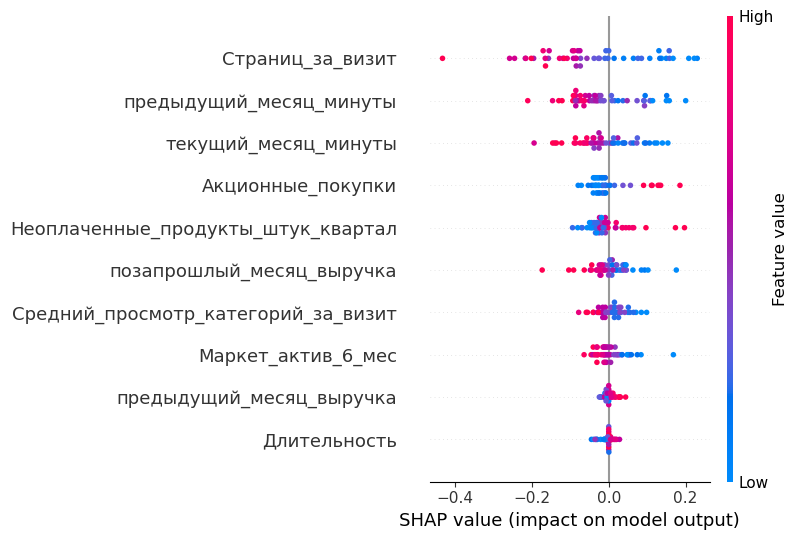

In [67]:
explainer = shap.KernelExplainer(best_model.predict, X_train_preprocessed_smpl)
shap_values = explainer.shap_values(X_test_preprocessed_smpl)

# Построение графика с именами признаков
shap.summary_plot(shap_values, X_test_preprocessed_smpl, max_display=10)

Самыми влиятельными признками оказались:
1. Cтраниц за визит -- высокое значение страниц товаров, которое просмотрел пользователь снижает вероятность принадлежности к классу 1
2. Время проведенное на сайте значительно влияет на вероятность принадлежности к классу 1.
3. Также высокое значение акционных покупок позволяет уудержать пользователей
4. Маркетинговая активность в текущем месяце значительно хуже, чем за прошлые 6 месяцев.

### Итог по анализу важности признаков

<div  style="border-radius: 10px; border: 2px solid; padding: 40px ">

1. Была выделена лучшая модель и построен график важности с помощью метода SHAP.
2. Самыми влиятельными признками оказались: __Cтраниц за визит__, __время проведенное на сайте__ и __акционные покупки__

## Сегментация покупателей <a id='7'>

8.1 Выполните сегментацию покупателей. Используйте результаты моделирования и данные о прибыльности покупателей.

8.2 Выберите группу покупателей и предложите, как увеличить её покупательскую активность:     
Проведите графическое и аналитическое исследование группы покупателей.     
Сделайте предложения по работе с сегментом для увеличения покупательской активности.    

8.3 Сделайте выводы о сегментах:     
какой сегмент вы взяли для дополнительного исследования, какие предложения вы сделали и почему.

In [68]:
# Зададим порог вероятности

threshold = 0.75

# 8.1 Выполните сегментацию покупателей. Используйте результаты моделирования и данные о прибыльности покупателей.
# Применим модель для всех данных
best_model = gs.best_estimator_

# gеременная predictions будет содержать массив вероятностей того, что каждый образец принадлежит к классу 1
predictions = best_model.predict_proba(X)[:, 1]

# prediction_flags cодержать массив, где True соответствует образцам,
# которые модель считает принадлежащими к классу 1 с вероятностью выше заданного порога
prediction_flags = np.where(predictions > threshold, True, False)

In [69]:
# Отберем данные, где модель предсказала класс 1 -> Снижение
df_raw_segment = df.loc[prediction_flags]

In [70]:
df_income = df_income.set_index('id')

In [71]:
df_seg = pd.merge(df_raw_segment, df_income, left_index=True, right_index=True)

In [72]:
df_seg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 387 entries, 215349 to 216636
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Покупательская активность            387 non-null    object 
 1   Тип сервиса                          387 non-null    object 
 2   Разрешить сообщать                   387 non-null    object 
 3   Маркет_актив_6_мес                   387 non-null    float64
 4   Маркет_актив_тек_мес                 387 non-null    int64  
 5   Длительность                         387 non-null    int64  
 6   Акционные_покупки                    387 non-null    float64
 7   Популярная_категория                 387 non-null    object 
 8   Средний_просмотр_категорий_за_визит  387 non-null    int64  
 9   Неоплаченные_продукты_штук_квартал   387 non-null    int64  
 10  Ошибка_сервиса                       387 non-null    int64  
 11  Страниц_за_визит             

Выделим сегмент пользователей, в котором будут признаки наиболее влиятельные для снижения пользовательской активности.   
А именно:    
1. Страниц за визит
2. Предыдущий месяц минуты
3. Текущий месяц минуты
4. Акционные покупки
5. Неоплаченные продукты

По данному сегменту произведем грфически-аналитическое исследование

### Анализ сегмента

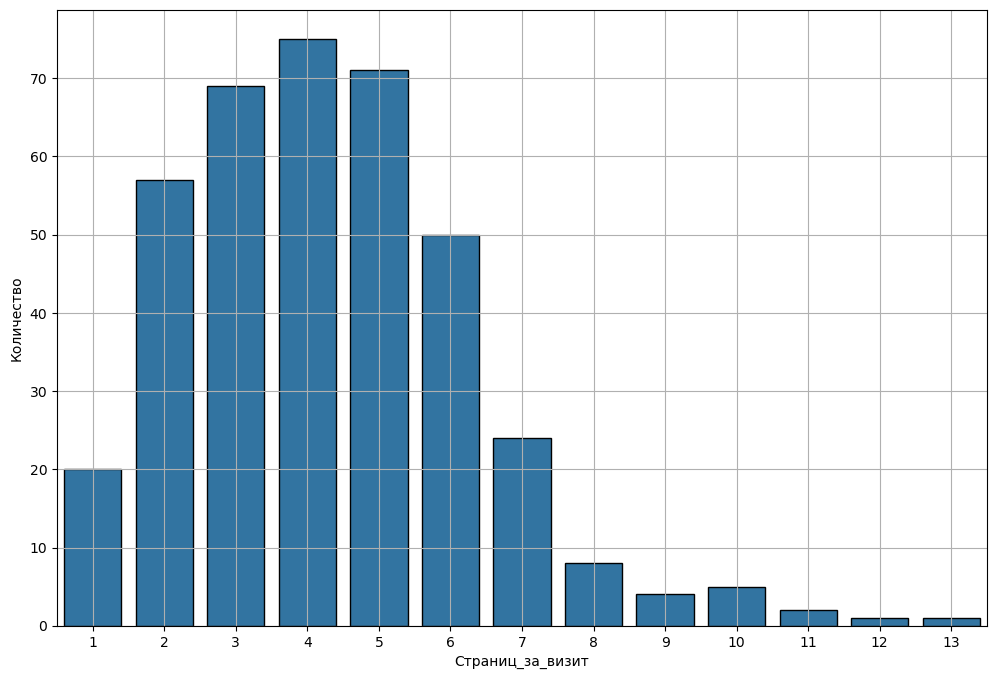

In [73]:
discrete_search_plot(df_seg['Страниц_за_визит'], 'Страниц_за_визит')

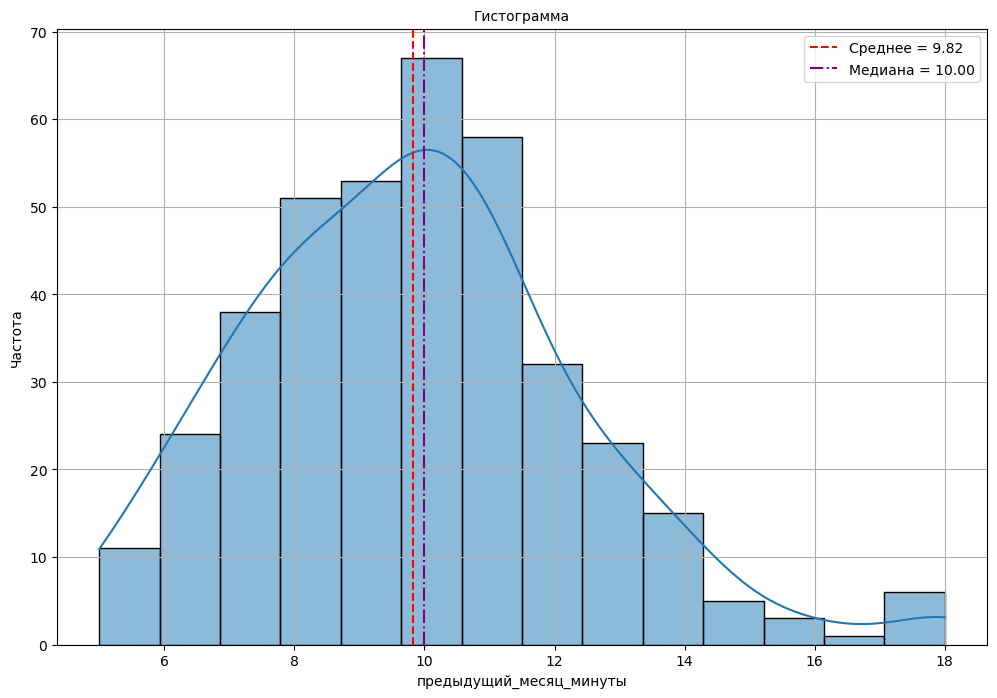

In [74]:
short_search_plot(df_seg['предыдущий_месяц_минуты'], 'предыдущий_месяц_минуты', bins = 14)

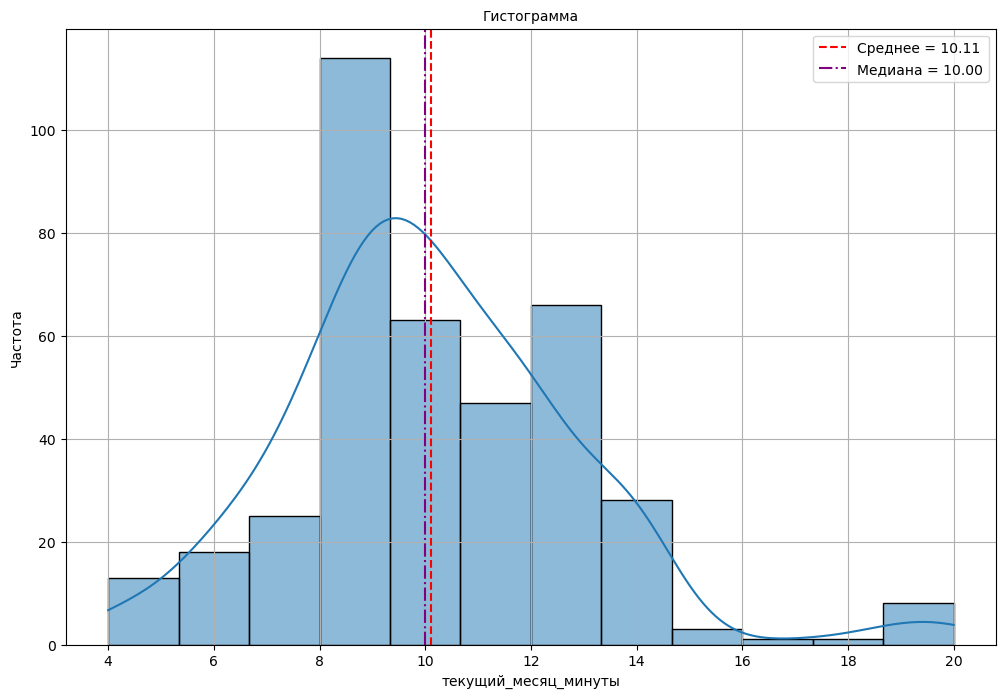

In [75]:
short_search_plot(df_seg['текущий_месяц_минуты'], 'текущий_месяц_минуты', bins = 12)

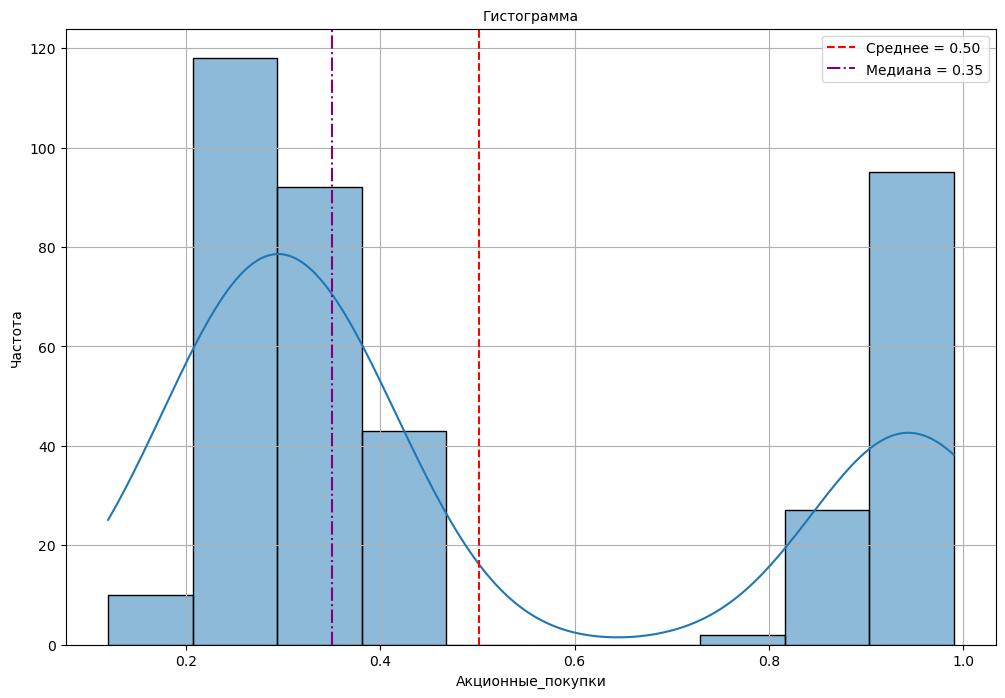

In [76]:
short_search_plot(df_seg['Акционные_покупки'], 'Акционные_покупки', bins = 10) 

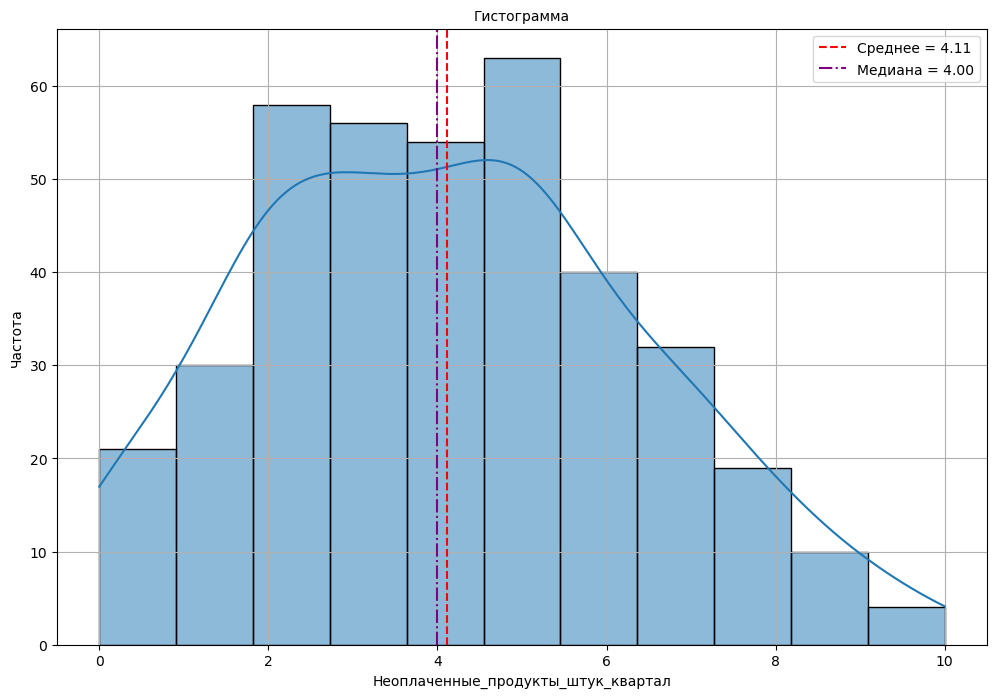

In [77]:
short_search_plot(df_seg['Неоплаченные_продукты_штук_квартал'], 'Неоплаченные_продукты_штук_квартал', bins = 11)

По этим признакам можно заметить, что данные пользователи:
1. В среднем совершают покупки только по акциям (Ср.знч. = 0.5)
2. Хранят больше неоплаченных товаров в корзине
3. Проводят меньше времени на сайте
4. Посещают меньше страниц

----

Для интереса посмотрим какие категории наиболее часто покупают данные пользователи

---

Популярная_категория
Домашний текстиль                       19.0
Косметика и аксесуары                   22.0
Кухонная посуда                         15.0
Мелкая бытовая техника и электроника     5.0
Техника для красоты и здоровья           8.0
Товары для детей                        31.0
Name: Популярная_категория, dtype: float64

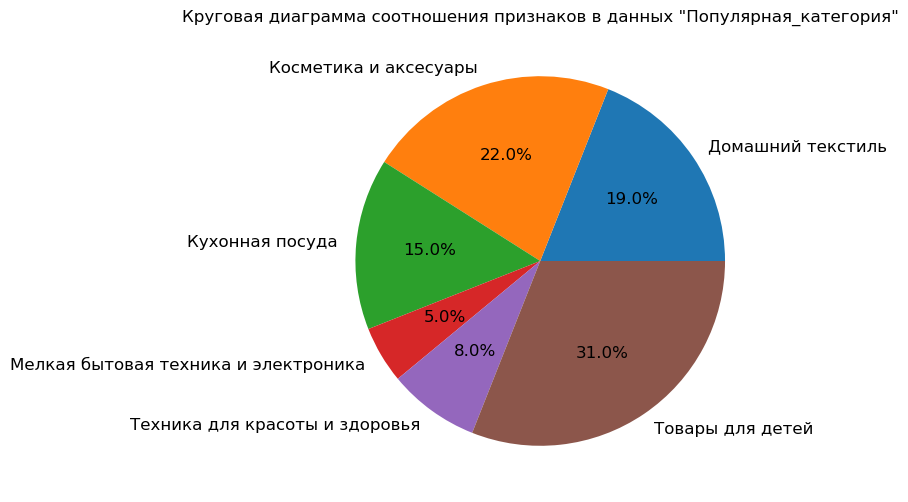

In [78]:
search_сategory(df_seg, 'Популярная_категория', '"Популярная_категория"')

В основном это товары для детей, домашний текстиль и косметика.

### Итог по сегментации покупателей

<div  style="border-radius: 10px; border: 2px solid; padding: 40px ">

На основе проведенного анализа сегмента пользователей, прошу обратить внимание на следующие аспекты:

1. Пользователи в данном сегменте совершают покупки преимущественно по акциям, что подтверждается средним значением акционных покупок, равным 0.5.
2. Пользователи хранят в корзине больше неоплаченных товаров, что может указывать на необходимость улучшения процесса оформления заказа или предоставления дополнительных стимулов для завершения покупок.
3. Также было обнаружено, что пользователи проводят меньше времени на сайте и посещают меньше страниц, что может свидетельствовать о недостаточной вовлеченности или интересе к контенту.

Среди наиболее популярных категорий товаров в этом сегменте выделяются:
- товары для детей
- домашний текстиль
- косметика

Это открывает возможности для целенаправленных маркетинговых акций и улучшения пользовательского опыта.

Рекомендуем следующие действия для увеличения покупательской активности данного сегмента:

- **Разработка специальных акций и предложений**, ориентированных на популярные категории товаров, что может стимулировать пользователей к совершению покупок.
- **Предложение аналогичных товаров по более низкой цене**, так как данные пользователи стараются взять товары подешевле.    
- **Оптимизация процесса оформления заказа** для снижения количества неоплаченных товаров в корзине, возможно, с помощью напоминаний или предложений по завершению покупки.
- **Улучшение контента на сайте**, чтобы увеличить время, проводимое пользователями на платформе, и повысить их вовлеченность.
 

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Молодец, в разделе выбора сегмента и разработки маркетинговых предложений по увеличению покупательской активности для него я не вижу никаких проблем. Проведен и аналитический и графический анализ, в выводе находится саммари по всем, наиболее значимым поинтам анализа. Что же касается рекомендаций, то конечно здесь написать можно много ... твой анализ (и графики для признаков) дают массу полезной информации о характеристиках 2х групп покупателей. Написать можно много, но для начала достаточно и тех моментов, которые упоминаешь здесь ты. Молодец!
</div>

## Итоговый вывод  <a id='8'>

<div  style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">
    
1. **В начале проекта была поставлена следующая задача**:     

     - Разработать модель, которая предскажет вероятность снижения покупательской активности.
     - Выделить сегмент покупателей, проанализировать его и предложить, как увеличить его покупательскую активность.
    
    
2. **Обработка данных**:
    
    - Были устранены неявные дубликаты   
    - Исправлены орфографические ошибки

    
3. **Поиск лучшей модели**:
    
    - Была проведена подготовка тренировочной и валидационной выборки. 
    - Создан единый пайплан, который содержит в себе масштабирование входных признаков и 4 модели.
    - Использованы два метода подбора гиперпараметров:
        - _RandomSearchCV_     
        - _GridSearchCV_     
    - Лучшая модель -- **SVC** с метрикой __roc_auc = 0.912__
    
    
4. **Анализ сегмента**:

    - Разработка специальных акций и предложений, ориентированных на популярные категории товаров, что может стимулировать пользователей к совершению покупок.
    - Предложение аналогичных товаров по более низкой цене, так как данные пользователи стараются взять товары подешевле.    
    - Оптимизация процесса оформления заказа для снижения количества неоплаченных товаров в корзине, возможно, с помощью напоминаний или предложений по завершению покупки.
    - Улучшение контента на сайте, чтобы увеличить время, проводимое пользователями на платформе, и повысить их вовлеченность